In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   1.945875  0.498755 -0.278910 -0.197037  0.653197  0.006112  1.027407   
  1   0.377004  0.272865 -0.176656 -0.000131 -0.025397  0.489134  0.841090   
  2  -0.218011  1.047458  0.936515  0.291826  0.276944  0.296950  0.461672   
  3   0.937583  0.476033  0.327037 -0.312055 -0.083535  0.231144  0.420494   
  4   0.578472 -0.050185 -0.734012 -0.177291  0.343352  0.424128  1.031059   
  5   1.013478  0.481767 -0.690592  0.332882  1.075926  0.840504  1.093019   
  6   0.031967  0.166284 -0.277995  0.058299  0.704952  0.414138  0.177568   
  7   0.355292  0.468563  0.204325  0.872316  0.169091  1.016025  0.151636   
  8  -0.594732  0.495297  0.780140  0.509808 -0.722289 -0.119673  0.589626   
  9   1.599043  0.514842  0.129340 -0.801024  0.902571  0.074941  0.137876   
  10  0.192385 -0.368359  0.259625 -0.636789  1.125593  0.367387  0.692363   
  11  0.841358  0.109678 -0.415002 -0.736931  0.542617  0.351986  0.222384   
  12  0.644163 -1.035865 -0.835350 -0.537750  0.368167 -0.417291  0.139454   
  13  0.533369 -0.088586  0.561237  0.019305 -0.413703 -0.876375  0.068718   
  14 -1.126153 -0.922181  0.541373  0.154021  0.633078  0.086252  0.221853   
  15 -0.135900 -0.384069 -0.458917  0.591262 -0.064212  0.041265  0.676917   
  16  0.252564 -0.137193  0.488490 -0.571050 -0.043514 -0.888687 -0.388342   
  17 -0.026430  0.127228 -0.763640 -0.695889  0.809783  0.623413  0.328979   
  18 -0.536588  0.259959 -0.715242 -0.440163  0.215846 -0.288602  0.690938   
  19  0.878016  1.290247  1.197178  1.260501  1.130599  0.411643  0.044260   
  20  0.705038  0.570822  0.712673  0.323220  1.618761  0.533954  0.354389   
  21  1.124975  0.115316  0.037431  0.425907  0.062544  0.496413  0.378544   
  22 -0.650865  0.261991 -0.098117 -0.262465  0.445230 -0.595846  0.466671   
  23  0.812303 -0.258620  0.041557 -0.133787  1.135072  0.197560  0.892054   
  24 -0.723755 -1.116588 -0.422758 -0.002845  0.899086  0.362384  0.731342   
1 0   0.612409  0.354419 -0.712340  0.311545 -0.245881 -0.666823  0.961871   
  1  -0.403770  0.279668 -0.271072 -0.474288 -0.764176  0.108776  0.927196   
  2   0.804244  0.658278 -0.466615 -0.514570  0.215523  0.016130 -0.328328   
  3  -0.609503 -0.011725  0.843279 -0.495291 -0.068889  0.038024  0.261036   
  4  -0.817742  0.336299 -0.315250  0.294092 -0.463596 -0.617114  0.137174   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.240921 -0.839155 -0.212818  ...  0.517216 -0.433474 -0.686078   
  1   0.106368  0.182316 -0.622720  ... -0.345864 -0.001146  0.818619   
  2   0.808203  0.366555  0.753210  ...  0.162311 -0.278002 -0.478914   
  3   0.254068 -1.344036 -0.636447  ...  0.110943  0.392721 -0.077320   
  4   0.658434 -0.564603 -0.042623  ... -0.454570 -0.765911 -0.334924   
  5   0.279402 -0.929789 -0.332979  ...  0.484032 -0.051856 -0.011344   
  6   0.225363 -0.408597 -0.585104  ... -1.258883 -0.524557 -1.207483   
  7   0.342696 -0.138935 -0.123729  ...  0.032893 -0.034712 -0.363472   
  8   1.810162 -0.795527 -0.509269  ...  0.700321  0.193126 -0.543069   
  9   0.231710 -0.485817 -0.258693  ...  1.055973  0.220800 -0.344022   
  10  0.862642  0.075584  0.350033  ...  0.084821  0.217207 -0.480431   
  11  0.898804 -0.013894  0.176593  ...  0.662996  0.533493  0.161607   
  12  0.368308 -0.062246 -0.622894  ...  0.117366  1.381529  0.245860   
  13  0.335653 -0.471903  0.076383  ...  0.683126  0.549472  0.711554   
  14  0.337637  0.319294 -0.592447  ...  0.046965  0.662451  0.642209   
  15 -0.290255 -1.100465  0.268554  ...  0.935009  0.112025 -1.156641   
  16 -0.027874 -0.375061 -0.079724  ...  1.453271  0.097959  0.000217   
  17 -0.200080  0.365672 -0.639040  ...  0.644465  0.090383 -0.880774   
  18 -0.111918  0.288387 -0.387051  ...  0.077928 -0.187241 -0.570337   
  19  0.588911  0.398318  0.362469  ...  0.014067 -0.332200  0.118111   
  20 -0.390540  0.203283  0.046944  ...  0.375480  0.171786 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t         P>|t|     2.5 %    97.5 %
D  0.932549  0.046171  20.197727  1.025082e-90  0.842056  1.023043


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



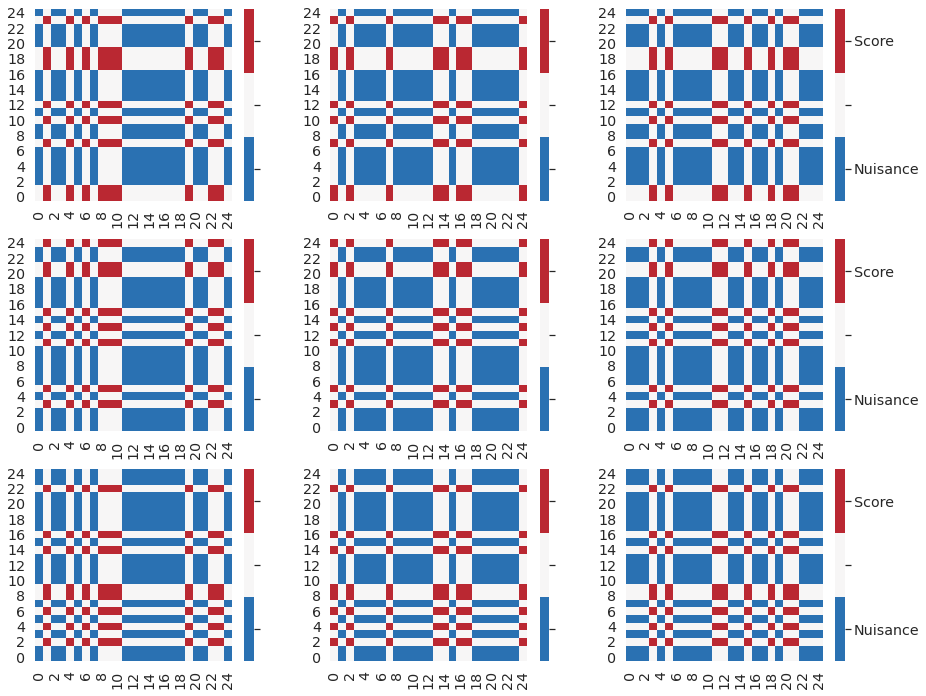

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



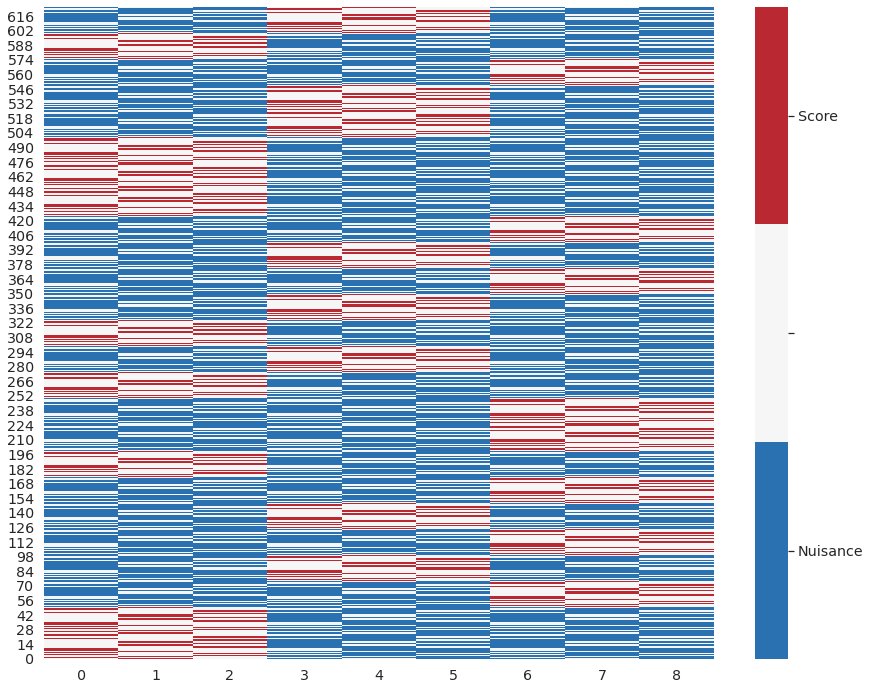

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])